In [35]:
import numpy as np
from matplotlib import rc
import matplotlib.pylab as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set()
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
import pandas as pd

##  Tactile and auditory neurons

The tactile area is composed of an array of $(M_t = 40)\mathrm{x}(N_t = 20) = 800$ neurons. The distance between the center of the receptive fields ($\mathrm{RF}$s) of adjacent tactile neurons is 0.5cm along both dimensions, so the array of neurons code for a portion of skin of $(20 \mathrm{x} 10)$cm. The center of the RF of each neuron is thus $x^t_i = 0.5i$cm and $y^t_j = 0.5j$cm.

The auditory area is composed of an array of $(M_a = 20)x(N_a = 3)=60$ neurons. The distance between the center of the receptive fields ($\mathrm{RF}$s) of adjacent auditory neurons is 10 cm along both dimensions, so the array of neurons code for a portion of space of $(200 \mathrm{x} 30$cm on and around the hand. If we consider a reference frame rigidly connected to the hand, the center of the RF of each neuron is thus $x^a_i = 10i − 5$ and $y^a_j = 10j − 15 $cm.

### Setting up the stimuli

The input to each neuron is defined by the convolution between the input and the receptive field:

<center>
$\varphi_{ij}^s(t) = \sum_l \sum_n \Phi_{ij}^s (x_l, y_n) I^s(x_l, y_n, t) \Delta x_l \Delta y_n$,
</center>

where $s = \{t,a\}$ for tactile and auditory neurons respectively, and $\Delta x = \Delta y = 0..2$cm.

The tactile and auditory stimuli at time $t$, $I^s(x,y,t)$, are described as a Gaussian function with amplitude $I_0^s$ and spatial extension $\sigma^s_I$, centered on the stimulus center, $x_0,y_0$, in their respective space. Therefore,

<center>
$I^{s}(x, y, t)=I_{0}^{s} \exp \left(-\frac{\left(x-x_{o}\right)^{2}+\left(y-y_{o}\right)^{2}}{2 \sigma_{I}^{2}}\right),$
</center>

if $t \geq t_0$, where $t_0$ is the time when the stimulus is shown. $I_0^t$ was set to 46.875, and $I_0^a$ to 67.5. The statial extension, $\sigma_I^s$ was set to 0.3.

The receptive fields of each neuron are also described by a Gaussian function. The RF of neuron $i,j$ is described by

<center>
$\Phi_{i j}^{s}(x, y)=\Phi_{0}^{s} \cdot \exp \left(-\frac{\left(x-x_{i}^{s}\right)^{2}+\left(y-y_{j}^{s}\right)^{2}}{2 \cdot\left(\sigma_{\Phi}^{s}\right)^{2}}\right) $
</center>

The amplitude of the receptive field, $\Phi^s_0$ was set to 1. The spatial extensions were set to $\sigma_\Phi^t = 1$ and $\sigma_\Phi^a = 10$.

### Setting up the lateral connections

The lateral connections were implemented using a mexican-hat type of connectivity, where neurons close to each other fire each other and neurons far from each other inhibit each other. 

The lateral connection between a neuron $i,j$ and a neuron $h,k$ is implemented as a difference of Gaussians.

<center>
$L_{i j, h k}^{s}=\left\{\begin{array}{ll}
{L_{e x}^{s} \cdot \exp \left(-\frac{\left(D_{x}^{s}\right)^{2}+\left(D_{y}^{s}\right)^{2}}{2 \cdot\left(\sigma_{e x}^{s}\right)^{2}}\right)-L_{i n}^{s} \cdot \exp \left(-\frac{\left(D_{x}^{s}\right)^{2}+\left(D_{y}^{s}\right)^{2}}{2 \cdot\left(\sigma_{i n}^{s}\right)^{2}}\right),} & {i j \neq h k} \\
{0,} & {i j=h k}
\end{array}\right.$
</center>

where $D_x^s$ and $D_y^s$ indicate the distances along the horizontal and vertical axes respectively. 

The amplitude of the Gaussians for the tactile neurons, $L^t_{ex} \text{ and } L^t_{in}$ are 0.15 and 0.05, while the spatial extensions are $\sigma^t_{ex}=20$cm and $\sigma^t_{in}=80$cm.

The amplitude of the Gaussians for the auditory neurons, $L^a_{ex} \text{ and } L^a_{in}$ are 0.15 and 0.05, while the spatial extensions are $\sigma^t_{ex}=1$cm and $\sigma^t_{in}=4$cm.

These values are represented as a $4-\mathrm{d}$ array $L$, where $L_{ij}$ is a $2-\mathrm{d}$ array representing the connections from neuron $i,j$ to all other neurons.

The parameters $L_{ex}^s, \sigma_{ex}^s$ and $L_{in}^s, \sigma_{ex}^s$ can be changed to experiment, but they should always follow that $L_{ex}^s > L_{in}^s$ and $\sigma_{ex}^s < \sigma_{in}^s$ to maintain the mexican-hat type of connectivity.

In [2]:

class UniSensory():
    """ Simulating unisensory neurons.
    
    Contains the functions to simulate the unisensory neurons
    in space, the unisensory inputs and the lateral connections
    of unisensory neurons.
    
    Args:
    - t_0 (int): Time when the stimuli are applied (ms)
    - lateral ((float)): 4 numbers representing
        - amplitude of excitatory gaussian.
        - amplitude of inhibitory gaussian.
        - spatial extension of excitatory gaussian.
        - spatial extension of inhibitory gaussian.
    """
    
    def __init__(self, t_0, lateral):
        
        # For the convplution
        self.delta_x = self.delta_y = 0.2
        self.t_0 = t_0
        
        # Amplitude of receptive field
        self.RF_amplitude = 1
        # Spatial extension of stimulus.
        self.I_spatial_extension = 0.3
        # Amplitude of excitatory gaussian
        self.ex_amplitude = lateral[0]
        # Amplitude of inhibitory gaussian
        self.in_amplitude = lateral[1]        
        
    def find_cord(self, x, y):
        """ Given a coordinate in the auditory/tactile space, 
        return the numpy indexes of the neuron at those coordinates.
        """
        return np.argwhere((self.xx==x) & (self.yy==y))[0]
    
    def get_I(self, x, y, x_0, y_0):
        """ Get the stimulus at a point.
        Args:
        - x (float): the x-coordinate of the point
        - y (float): the y-coordinate of the point
        - x_0 (float): the x-coordinate of the stimulus location.
        - y_0 (float): the y-coordinate of the stimulus location.
        """
        return (self.I_amplitude * 
                np.exp(((x - x_0) ** 2 + (y - y_0) ** 2 ) / 
                        (-2 * self.I_spatial_extension ** 2)))
    
    def get_RF(self, i, j, x, y):
        """ Receptive field of the neuron at (i,j) on point (x,y).
        Args:
        - i (float): the x-coordinate of the neuron
        - j (float): the y-coordinate of the neuron
        - x (float): the x-coordinate of the point
        - y (float): the y-coordinate of the point
        """
        return (self.RF_amplitude * 
                np.exp(((x - i) ** 2 + (y - j) ** 2) / 
                       (-2 * self.RF_spatial_extension**2)))
    
    def get_stimuli(self, conv_x, conv_y, x_0, y_0):
        """ Get a matrix with the stimulus received by each neuron.
        Gets the stimulus for each neuron and adds it to the grid.
        Args:
        - conv_x (np-array): a numpy meshgrid with the x-cords
                             to use for convolution.
        - conv_y (np-array): a numpy meshgrid with the y-cords
                             to use for convolution.
        - x_0 (float): the x-coordinate of the stimulus.
        - y_0 (float): the y-coordinate of the stimulus.
        """
        grid = np.zeros(self.xx.shape)
        for ind_x, ind_y in np.ndindex(self.xx.shape):
            grid[ind_x, ind_y] = self.get_stimulus(ind_x, ind_y, 
                                                   conv_x, conv_y, 
                                                   x_0, y_0)
        return grid
        
    def get_stimulus(self, ind_i, ind_j, conv_x, conv_y, x_0, y_0):
        """ Gets the stimulus for a neuron by doing the convolution.
        The function is vectorized for numpy.
        Args:
        - ind_i (int): first index of the neuron
        - ind_j (int): second index of the neuron
        - conv_x (np-array): a numpy meshgrid with the x-cords
                             to use for convolution.
        - conv_y (np-array): a numpy meshgrid with the y-cords
                             to use for convolution.
        - x_0 (float): the x-coordinate of the stimulus.
        - y_0 (float): the y-coordinate of the stimulus.
        """
        # Get the spatial coordinates of the neuron
        i, j = self.xx[ind_i,ind_j], self.yy[ind_i, ind_j]
        
        # Return the sum of the matrix resulting from performing
        # get_RF * get_I * delta_x * delta_y for each
        # element of (conv_x, conv_y).
        return np.sum(self.get_RF(i, j, conv_x, conv_y) * 
                      self.get_I(conv_x, conv_y, x_0, y_0) * 
                      self.delta_x * self.delta_y)
    
    def stimulus(self, t, x, y, cord=False):
        """ Get the stimulus for a specific neuron
        at time t.
        Args:
        - t (int): time (ms)
        - x (float): x-cord of the neuron
        - y (float): y-cord of the neuron.
        - cord (bool, default=False): whether x,y are given as
            coordinates in the real space (True) or numpy indexes.
        """
        if cord:
            x, y = self.find_cord(x,y)
        return self.stimuli[x,y] if t >= self.t_0 else 0
        
    def plot_stimulus(self, annot=False, save=None):
        """Plot a heatmap of the stimulus."""
        title = f'{self.__str__()} stimuli for an impulse on $({self.x_0},{self.y_0})$cm'
        return self.plot(self.stimuli, title, rectangle=self.rectangle, 
                         annot=annot, save=save)
            
    def get_mh_connection(self, ind_x, ind_y, ind_x2, ind_y2, bias=0):
        """ Get a connection of the mexican hat
        Args:
        - ind_x (int): x-cord of first neuron
        - ind_y (int): y-cord of first neuron
        - ind_x2 (int): x-cord of second neuron
        - ind_y2 (int): y-cord of second neuron
        - bias (int, default 0): a bias term
        """
        # Get the spatial coordinates of the neurons
        x, y = self.xx[ind_x, ind_y], self.yy[ind_x, ind_y]
        x2, y2 = self.xx[ind_x2, ind_y2], self.yy[ind_x2, ind_y2]
        
        return (-bias + (self.ex_amplitude * np.exp(((x - x2) ** 2 + (y - y2) ** 2 ) / 
                                            (-2 * self.ex_std ** 2))) - 
               (self.in_amplitude * np.exp(((x - x2) ** 2 + (y - y2) **2 ) / 
                                           (-2 * self.in_std ** 2))))
        
    def mexican_hat(self, bias=0):
        """ Get the connections of the mexican hat.
        Returns a 4d array, L, where
            L[j,i] is a 2d array with the connections
            of neuron ij to all other neurons.
        Args:
        - bias (float, default 0): a bias term 
            for all connections
        """
        # Creating a 4d array to hold all connections
        grid = np.zeros(self.xx.shape + self.xx.shape)

        # Iterate through all the matrices in the array
        for super_ind_x in range(grid.shape[0]):
            for super_ind_y in range(grid.shape[1]):

                # Create a subgrid to get the connections for the
                # neuron we are in
                subgrid = grid[super_ind_x, super_ind_y]                
                for ind_x, ind_y in np.ndindex(subgrid.shape):
                    if ind_x == super_ind_x and ind_y == super_ind_y:
                        # A neuron cannot excite itself
                        grid[super_ind_x, super_ind_y, ind_x, ind_y] = 0
                                        
                    else:
                        grid[super_ind_x, super_ind_y, 
                             ind_x, ind_y] = self.get_mh_connection(super_ind_x, 
                                                                    super_ind_y, 
                                                                    ind_x, ind_y, 
                                                                    bias=bias)
        return grid
    
    def plot_lateral(self, x, y, cord=True, title=None, save=None):
        """ Plot the lateral connections.
        Args:
        - x (float): x coordinate of target neuron
        - y (float): y coordinate of target neuron
        - cord (bool, default True): whether x and y are passed as spatial
            coordinates or indices.
        - title (str, optional): custom title
        - save(str, default None): name of file
        """
        if not title:
            title = f'{self.__str__()} lateral synapses for the neuron at $({x},{y})$cm'
        if cord:
            x, y = self.find_cord(x, y)
            
        self.plot(self.lateral[x,y], title, 
                  cmap='PuOr_r', center=0, rectangle=self.rectangle, save=save)
        
    def plot(self, grid, title, xlabel=r'$x$ (cm)', ylabel=r'$y$ (cm)', 
             rectangle=True, rectangle_color='black', cmap='PuOr_r', 
             center=0, annot=False, save=None):
        """Helper function for plotting."""
        df = self.make_df(grid)
        f, ax = plt.subplots(figsize=self.figsize)
        sns.heatmap(df, cmap=cmap, center=center, annot=annot)
        ax.set_title(title, fontsize=20)
        ax.set_xlabel(xlabel, fontsize=18)
        ax.set_ylabel(ylabel, fontsize=18)
        if rectangle:
            ax.add_patch(
                patches.Rectangle(
                    (0.02,1),2,1,linewidth=1.5,
                    edgecolor=rectangle_color,facecolor='none'))
        if save:
            plt.tight_layout()
            f.savefig(f'report/fig/{save}.pdf', format='pdf')
        return ax
            
    def make_df(self, grid):
        return pd.DataFrame(grid, index=self.yy[:, 0], columns=self.xx[0,:])
        
        
class Tactile(UniSensory):
    """ Tactile neurons
    Args:
    - t_0 (float): time at which the impulse is given.
    - x_0 (float): x coordinate of the impulse.
    - y_0 (float): y coordinate of the impulse
    - lateral (default (0.15,0.05, 1, 4)):
        - amplitude of excitatory gaussian.
        - amplitude of inhibitory gaussian.
        - spatial extension of excitatory gaussian.
        - spatial extension of inhibitory gaussian.
    - lateral_bias (float, default 0): a bias for
        the lateral connectivities.
    """
    
    def __init__(self, t_0, x_0, y_0, 
                 lateral=(0.15,0.05, 1, 4), lateral_bias=0):
        super(Tactile, self).__init__(t_0, lateral[:2])
        # Meshgrid for the spatial coordinates
        self.xx, yy = np.meshgrid(np.arange(0.5, 20.5, 0.5), 
                                       np.arange(0.5, 10.5, 0.5))
        # y needs to be flipped to have negative values
        # on the bottom
        self.yy = np.flipud(yy)

        self.I_amplitude = 62.5 * 9 / 12
        self.RF_spatial_extension = 1
        
        # Similar to xx and yy, but with a smaller step
        # for the convolution.
        (conv_x, 
         conv_y) = np.meshgrid(np.arange(0.5, 20 + 0.2, 0.2), 
                               np.arange(0.5, 10 + 0.2, 0.2))
        self.stimuli = self.get_stimuli(conv_x, conv_y, x_0, y_0)
        # Stimulus coordinates
        self.x_0, self.y_0 = x_0, y_0

        self.ex_std, self.in_std = lateral[2:]
        
        # Simulating the lateral connections
        self.lateral = self.mexican_hat(bias=lateral_bias)
        
        # Setting the figure size
        self.figsize=(10,5)
        
        # Tactile neurons do not need a rectangle as
        # they are the smaller space.
        self.rectangle = False
        
    def __str__(self):
        return 'Tactile'

        
class Auditory(UniSensory):
    """Simulating auditory neurons.
    Args:
    - t_0 (float): time at which the impulse is given.
    - x_0 (float): x coordinate of the impulse.
    - y_0 (float): y coordinate of the impulse
    - lateral (default (0.15,0.05, 1, 4)):
        - amplitude of excitatory gaussian.
        - amplitude of inhibitory gaussian.
        - spatial extension of excitatory gaussian.
        - spatial extension of inhibitory gaussian.
    - lateral_bias (float, default 0): a bias for
        the lateral connectivities.
    """
    
    def __init__(self, t_0, x_0, y_0, 
                 lateral=(0.15, 0.05, 20, 80), lateral_bias=0):
        super(Auditory, self).__init__(t_0, lateral[:2])
        # Meshgrid for the spatial coordinates
        self.xx, yy = np.meshgrid(np.arange(5, 205, 10), 
                                  np.arange(-5, 25, 10))
        # y needs to be flipped to have negative values
        # on the bottom
        self.yy = np.flipud(yy)
        
        self.I_amplitude = 90 * 9 / 12
        self.RF_spatial_extension = 10
        
        self.ex_std, self.in_std = lateral[2:]
        self.lateral = self.mexican_hat(bias=lateral_bias)
        
        (conv_x, 
         conv_y) = np.meshgrid(np.arange(5, 200 + 0.2, 0.2), 
                               np.arange(-5, 20 + 0.2, 0.2))
        
        self.stimuli = self.get_stimuli(conv_x, conv_y, x_0, y_0)
        self.x_0, self.y_0 = x_0, y_0

        # Setting the figure size
        self.figsize = (20,3)
    
        # A rectangle for plotting the space of
        # tactile neurons.
        self.rectangle = True
        
    def __str__(self):
        return 'Auditory'
        



1. Input, $\varphi_{ij}^t(t)$, received by the tactile area neurons for a tactile stimulus placed at the center of the skin area (10, 5)

2. Input, $\varphi_{ij}^t(t)$, received by the auditory area neurons for an auditory stimulus placed at coordinates (100, 5). 

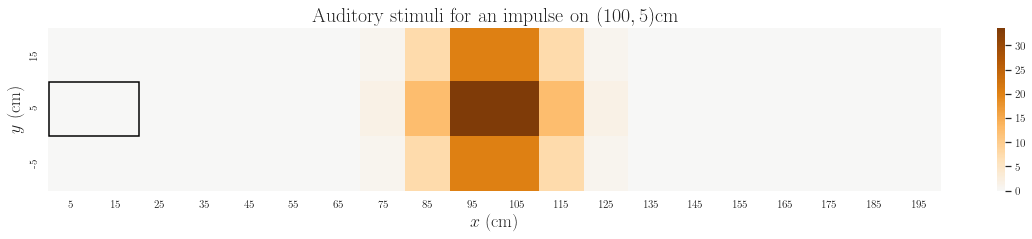

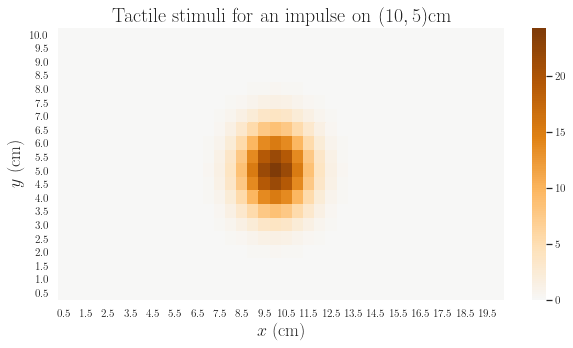

In [1634]:
a=Auditory(200, 100,5)
t=Tactile(200, 10, 5)

a.plot_stimulus()
t.plot_stimulus()

1. Lateral input for a tactile neuron located at the centre of the tactile area, on (10, 5)cm
2. Lateral input for an auditory neuron located on (10, 5)cm

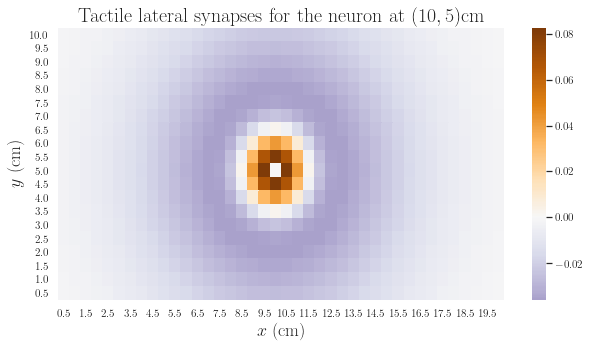

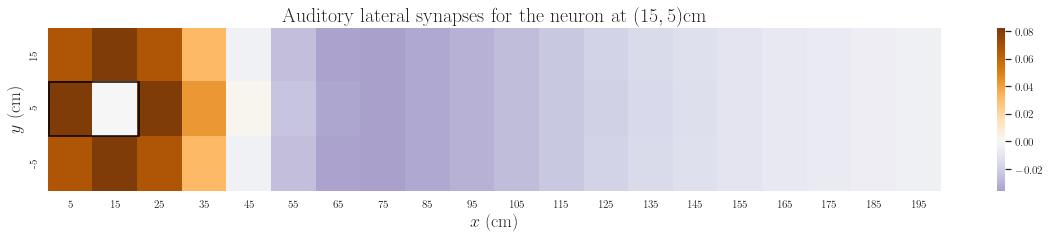

In [1635]:
t.plot_lateral(10,5)
a.plot_lateral(15,5)

## Feedforward and feedback connectivity with the multisensory neuron

The multisensory neuron is represented by one neuron only. It receives input from both unisensory areas, feedforward connectivity, and it sends input back to the unisensory neurons, feedback connectivity.

The weights of the synapses that connect the tactile neurons and the multisensory neuron are independent of the
position of the neuron in the tactile area. Therefore,

<center>
    $W^t_{ij} = W_0^t = 6.5 \text{, and } B^t_{ij} = B_0^t = 2.5$
</center>

where $W^t_{ij}$ and $B^t_{ij}$ represent the feedforward and feedback weight for neuron $ij$ respectively.

The weights of the synapses that connect the auditory neurons and the multisensory neuron depend on the distance of the auditory neurons relative to the hand: the synapses hold a constant weight ($W_0^a = 6.5 \text{, and } B_0^a = 2.5$) for the space on and near the hand, covering 65 cm of the auditory space (20 cm for the hand and 45 cm for the space close to the hand). The synaptic weights outside this boundary ($\mathrm{Lim} = 65$) are described by a bi-exponential function decreasing with the distance between the neurons’ RF and the hand:

<center>
    $W_{i j}^{a}=\alpha \cdot W_{0}^{a} \cdot \exp \left(-\frac{D_{i j}}{k_{1}}\right)+(1-\alpha) \cdot W_{0}^{a} \cdot \exp \left(-\frac{D_{i j}}{k_{2}}\right) \text{ and}$
</center>
<center>
    $B_{i j}^{a}=\alpha \cdot B_{0}^{a} \cdot \exp \left(-\frac{D_{i j}}{k_{1}}\right)+(1-\alpha) \cdot B_{0}^{a} \cdot \exp \left(-\frac{D_{i j}}{k_{2}}\right),$
</center>

where $\alpha = 0.9$, $k_1=15$cm and $k_2=800$cm.

In [42]:
class MultiSensory():
    """Simulating the multisensory neurons and creating
    instances for both types of unisensory neurons.
    Args:
    - aud_stimulus (defualt no stimulus): a tupple containing:
        (t_0, x_0, y_0) for the auditory stimulus.
    - tac_stimulus (defualt no stimulus): a tupple containing:
        (t_0, x_0, y_0) for the tactile stimulus.
    - aud_lateral (default (0.15, 0.05, 20, 80)): parameters
        for the auditory lateral connections.
    - aud_lateral (default (0.15, 0.05, 1, 4)): parameters
        for the tactile lateral connections.
    - Pruning (int, default 0): percentage of auditory
        connections to prune. Weakest pruned.
    - lateral_bias (float, default 0): bias for the lateral
        connections.
    """
    
    def __init__(self, aud_stimulus=(np.Infinity, 0, 0), 
                 tac_stimulus=(np.Infinity, 0, 0), 
                 aud_lateral=(0.15, 0.05, 20, 80), 
                 tac_lateral=(0.15, 0.05, 1, 4), pruning=False, 
                 lateral_bias=0):
        
        # Initializing auditory neurons
        self.auditory = Auditory(aud_stimulus[0], 
                                 aud_stimulus[1], 
                                 aud_stimulus[2], 
                                 lateral=aud_lateral, 
                                 lateral_bias=lateral_bias)
        # Initializing tactile neurons
        self.tactile = Tactile(tac_stimulus[0], 
                               tac_stimulus[1], 
                               tac_stimulus[2], 
                               lateral=tac_lateral,
                               lateral_bias=lateral_bias)
        
        # Parameters for the tactile weights
        tac_W_0, tac_B_0 = 6.5, 2.5
        # Matrices for the tactile weights
        tac_W = np.zeros(self.tactile.xx.shape) + tac_W_0
        tac_B = np.zeros(self.tactile.xx.shape) + tac_B_0

        # Parameters for the auditory weights
        aud_W_0, aud_B_0 = 6.5, 2.5
        alpha, k1, k2, lim = 0.9, 15, 800, 65
        
        # Getting the matrices for the auditory weights
        aud_W = self.get_connections(aud_W_0, lim, alpha, k1, k2)
        aud_B = self.get_connections(aud_B_0, lim, alpha, k1, k2)
        
        # Pruning the neurons if needed.
        if pruning:
            aud_W, aud_B = self.pruning(aud_W, aud_B, pruning)
            
        # Storing feedforward and feedback connectivities
        self.W = {'auditory': aud_W, 'tactile': tac_W}
        self.B = {'auditory': aud_B, 'tactile': tac_B}
        
    def get_connections(self, weight, limit, alpha, k1, k2):
        """ Getting the connection between the auditory
        area and the multisensory neuron, either 
        feedback (B) or feedforward (W).
        Args:
        - weight (array): the initial W or B weights
        - the limit from which to start the decay of 
            the weights.
        - alpha, k1, k2 are parameters of the equation.
        """
        grid = np.zeros(self.auditory.xx.shape)
        
        def exp_dist(ind_x, ind_y, k):
            """Auxiliary function, part of the main equation."""
            x, y = self.auditory.xx[ind_x, ind_y], self.auditory.yy[ind_x, ind_y]
            dist = 0 if x <= 65 else x - 65
            return np.exp(-dist / k)
        
        for ind_x, ind_y in np.ndindex(grid.shape):
            # For each auditory neuron, get the output of the equation.
            grid[ind_x, ind_y] = (alpha * weight * exp_dist(ind_x, ind_y, k1) + 
                                  (1 - alpha) * weight * exp_dist(ind_x, ind_y, k2))            
        return grid
        
    def plot_auditory_weights(self, direction, save=None):
        """ Function to plot the feedforward/feedback weights.
        Args:
        - direction (string): feedforward (forward, f, W, w)
            or feedback (otherwise).
        - save (string, default None): name of the figure.
        """
        if direction in ['forward', 'f', 'W', 'w']:
            grid = self.W['auditory']
            main_title = 'Feedforward'
        else:
            grid = self.B['auditory']
            main_title = 'Feedback'

        title = f'{main_title} auditory synapses ($W^a$)'
        self.auditory.plot(grid, title, annot=True, rectangle_color='w', save=save)
        
    def pruning(self, W, B, percent):
        """ Perform auditory pruning, pruns the given percentage
        of the weakest connections.
        Args:
        - W, B (array): feedforward and feedback auditory weights
        - percent (int): percentace to prune, from 1 to 100.
        """        
        # Number of elements to prune
        num = int(W.size * percent / 100)
        # Getting the num smallest values
        smallest_W = np.partition(W, num, axis=None)[:num]
        smallest_B = np.partition(B, num, axis=None)[:num]
        
        # For all the smallest values
        for n, W_i in enumerate(smallest_W):
            # We also need the feedback ones
            B_i = smallest_B[n]
            
            # Get the index of the small value
            W_ind = np.argwhere(W == W_i)[0]
            B_ind = np.argwhere(B == B_i)[0]
            # Set to 0
            W[W_ind[0], W_ind[1]] = 0
            B[B_ind[0], B_ind[1]] = 0
        
        # Return the pruned W and B matrices.
        return W, B

1. Feedforward weights between the auditory region and the multisensory neuron.
2. Feedback weights between the tactile region and the multisensory neuron.

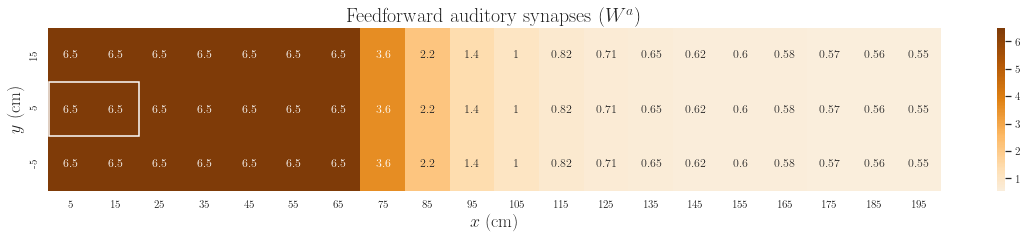

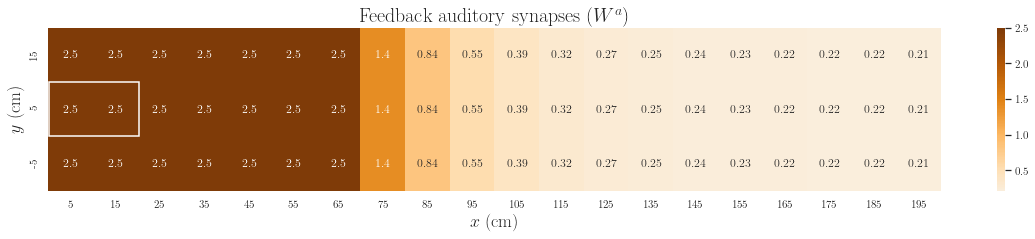

In [1637]:
m = MultiSensory()
m.plot_auditory_weights('f')
m.plot_auditory_weights('b')


## Responses of neurons

### Unisensory area

The neurons in the unisensory and multisensory area are modeled as rate neurons. For the unisensory areas, the rate of a neuron is given by the dynamic state, $q_{ij}(t)$, run by a sigmoid-like funciton $F$. 

The rate of a neuron is thus

<center>
    $z_{i j}^{s}(t)=\left[F\left(q_{i j}^{s}(t)\right)\right]_{+},$
</center>

where the $+$ represents that the sigmoid is set to 0 when negative, as we cannot have negative rates.

The sigmoid function is represented by

<center>
    $F\left(q_{i j}^{s}(t)\right)=\frac{f_{\mathrm{m i n}}^{s}+f_{\mathrm{m a x}}^{s} \cdot e^{\left(q_{i j}^{s}-q_{c}^{s}\right) \cdot r^{s}}}{1+e^{\left(q_{i j}^{s}-q_{c}^{s}\right) \cdot r^{s}}}$
</center>

where $f_{\mathrm{min}}^s = -0.12$, $f_{\mathrm{max}}^s = 1$, $q_c^s = 19.43$ and the center of the sigmoid, and $r^s=0.34$ and the slope at the center of the sigmoid.

The dynamic state of each neuron is given by a first order differential equation:

<center>
    $\tau \frac{d q_{i j}^{s}(t)}{d t}=-q_{i j}^{s}(t)+u_{i j}^{s}(t)$
</center>

where $\tau$, the time constant, is 20ms, and $u_{ij}^s(t)$ is the input to the neuron $ij$ at time $t$.

The input is given as the sum of the external input, $\varphi_{ij}^s$, the lateral inputs, $I_{ij}^s(t)$, and the feedback input $b^s_{ij}$. 

<center>
    $u_{i j}^{s}(t)=\varphi_{i j}^{s}+I_{i j}^{s}(t)+b_{i j}^{s}(t)$
</center>

The lateral input at $ij$ is given by the sum, for all neurons, of the activation of the neuron $hk$, $z_{h k}^{s}$ times the lateral input from $ij$ to $hk$, $L_{i j, h k}^{s}$.

<center>
    $I_{i j}^{s}=\sum_{h=1}^{N^{s}} \sum_{k=1}^{M^{s}} L_{i j, h k}^{s} \cdot z_{h k}^{s}(t)$
</center>

The feedback input is given by the feedback weights of neuron ${ij}$ times the activation of the multisensory neuron, $z^m(t)$. 

<center>
    $b_{i j}^{s}(t)=B_{i j}^{s} \cdot z^{m}(t)$
</center>

### Multisensory area

The multisensory neuron works in the same was as the unisensory areas. The rate, $z^m(t)$ is given by the same sigmoid that depends on the dynamic state, $q_{ij}^m(t)$ of the multisensory neuron. 

The parameters for the sigmoid, however, are different: $f_{\mathrm{min}}^m = 0$, $f_{\mathrm{max}}^m = 1$, $q_c^m = 12$ and the center of the sigmoid, and $r^m=0.6$ and the slope at the center of the sigmoid.

The dynamic state is given by a similar differential equation:

<center>
    $\tau \frac{d q^{m}(t)}{d t}=-q^{m}(t)+u^{m}(t)$
</center>

The input, $u^{m}(t)$ is given by the sum, for all unisensory neurons (both tactile and auditory) of the activation of the neuron $z_{ij}^s$ times the feedforward weight of the neuron $W_{ij}^s$. 

<center>
    $u^{m}(t)=\sum_{i=1}^{N^{t}} \sum_{j=1}^{M^{t}} W_{i j}^{t} \cdot z_{i j}^{t}(t)+\sum_{i=1}^{N^{a}} \sum_{j=1}^{M^{a}} W_{i j}^{a} \cdot z_{i j}^{a}(t)$
</center>

### Simulation algorithm

The general algorithm used is:

- Initialise a small q_0
- Calculate $\varphi^s$ based on the current time-step,
- Calculate $I^s$ and $b^s$ based on the previous time-step's $z^s$ and $z^m$,
- Update $u^s$, $z^s$, $u^m$, $z^m$.

In order to calculate $\varphi^s$ and $\varphi^m$ the differential equations had to be solved. This was done numerically using Euler's method:

<center>
    $ q_{ij}^s (t) =  q_{ij}^s (t-1) + \frac{\Delta t}{\tau} \big(q_{ij}^s (t-1)) + u_{ij}^s(t)\big), $
</center>

where $\Delta t$ is the time-step used for the simulation, which was set to 0.4ms.

### Reaction times
The reaction times, $RT^{90\%}$, are defined as the time at which the tactile neurons reach $90\%$ of their final activity. 

They are obtained by:

- Summing over the activations of the tactile neurons at the final time-step, $S$.
- For all timesteps:
    - Compute the sum of its activations, $s$.
    - If $s \geq 0.9 \cdot S$, return tue time.
    
To obtain realistic values of the reaction times, in miliseconds, we further use

<center>
    $ RT = 3 RT^{90\%} + 60$


In [37]:
class PPS():
    """Simulating the peri-personal space by calculating 
    reaction times and neuron activations based on 
    models of multisensory and unisensory neurons.
    Args:
    - aud_stimulus (defualt no stimulus): a tupple containing:
        (t_0, x_0, y_0) for the auditory stimulus.
    - tac_stimulus (defualt no stimulus): a tupple containing:
        (t_0, x_0, y_0) for the tactile stimulus.
    - aud_lateral (default (0.15, 0.05, 20, 80)): parameters
        for the auditory lateral connections.
    - aud_lateral (default (0.15, 0.05, 1, 4)): parameters
        for the tactile lateral connections.
    - Pruning (int, default 0): percentage of auditory
        connections to prune. Weakest pruned.
    - lateral_bias (float, default 0): bias for the lateral
        connections.
    """
    def __init__(self, time, 
                 aud_stimulus=(np.Infinity, 0, 0), 
                 tac_stimulus=(np.Infinity, 0, 0), 
                 aud_lateral=(0.15, 0.05, 20, 80), 
                 tac_lateral=(0.15, 0.05, 1, 4), 
                 pruning=False, 
                 lateral_bias=0):
        
        self.delta_t = 0.4
        # Linear arangment of the times to perform the simulation.
        self.times = np.arange(0, time + self.delta_t, self.delta_t)
        self.q_0 = 0.1
        
        # Paramreters for the equations.
        self.params = {'unisensory': {
                            'lower_bound': -0.12, 'upper_bound': 1, 
                            'central': 19.43, 'slope': 0.34}, 
                       'multisensory': {
                           'lower_bound': 0, 'upper_bound': 1, 
                           'central': 12, 'slope': 0.6},
                      'time_constant': 20}
        
        # Initializing the multisensory and unisensory neurons
        self.neurons = MultiSensory(aud_stimulus, tac_stimulus, 
                                    aud_lateral=aud_lateral, 
                                    tac_lateral=tac_lateral, 
                                    pruning=pruning, 
                                    lateral_bias=lateral_bias)
        
        # Initialising logs for the dynamic states and the rates.
        # The first time-step is initialised to q_0, which is
        # set as having a vary low value.
        ds_log = {'multisensory': [self.q_0],
                       'auditory': [np.zeros(self.neurons.auditory.xx.shape) + self.q_0],
                       'tactile': [np.zeros(self.neurons.tactile.xx.shape) + self.q_0]}
        
        z_log = {'multisensory': [self.sigmoidal(self.q_0, 'multisensory')],
                    'auditory': [np.zeros(self.neurons.auditory.xx.shape) + 
                                 self.sigmoidal(self.q_0, 'unisensory')],
                    'tactile': [np.zeros(self.neurons.tactile.xx.shape) + 
                                self.sigmoidal(self.q_0, 'unisensory')]}
        
        self.log = {'ds': ds_log, 'z': z_log}
    
    def simulate(self, fired=2):
        """Perform the simulation.
        Args:
        fired (default 1): set to 0 it the times when the
            multisensory neuron reaches 10 and 90 percent
            activity are needed.
        """
        for time in range(len(self.times))[1:]:  # at t=0 the conditions are given
            # Get the dymanic states for all areas
            auditory_ds = self.simulate_uni(self.neurons.auditory, 
                                            'auditory', time)
            tactile_ds = self.simulate_uni(self.neurons.tactile, 
                                           'tactile', time)
            multisensory_ds = self.simulate_multi(time, 
                                                  self.neurons.auditory, 
                                                  self.neurons.tactile)
            
            # Update the ds logs
            self.log['ds']['auditory'].append(auditory_ds)
            self.log['ds']['tactile'].append(tactile_ds)
            self.log['ds']['multisensory'].append(multisensory_ds)
            
            # Update the z logs by getting the sigmoidal output.
            self.log['z']['auditory'].append(
                self.sigmoidal(auditory_ds, 'unisensory'))
            self.log['z']['tactile'].append(
                self.sigmoidal(tactile_ds, 'unisensory'))
            multi = self.sigmoidal(multisensory_ds, 'multisensory')
            self.log['z']['multisensory'].append(multi)
            
            # For printing the times when the multisensory neuron
            # gets activated.
            if multi > 0.1 and fired < 1:
                print(f'Started firing {time * self.delta_t}')
                fired += 1
            if multi > 0.9 and fired < 2:
                print(f'Reached 0.9 at time {time * self.delta_t}')
                fired += 1
                
                
    
    def sigmoidal(self, dynamic_state, type_neuron):
        """Function to get the sigmoidal of a neuron.
        Numpy vectorized.
        Args:
        - dynamic_state (float or numpy array):
            of dynamic states.
        - type_neuron (str): auditory, tactile
                             or multisensory.
        """
        params = self.params[type_neuron]
        z =  ((params['lower_bound'] + params['upper_bound'] * 
               np.exp((dynamic_state - params['central']) * params['slope'])) / 
              (1 + np.exp((dynamic_state - params['central']) * params['slope'])))
        if type(z) == np.ndarray:
            z[z<0] = 0
            return z
        # We can only have positive or 0 rates
        else: return z if z >= 0 else 0  
            
    def simulate_uni(self, neurons, neuron_type, time):
        """ Perform the simulations for the unisensory
        neurons at a given time.
        Gets the input and performs Euler's method
        to get the next dynamic state.
        Args:
        - neurons (UniSensory): neurons to simulate
        - neuron_type (str): auditory or tactile
        - time (float): current time-step
        """
        grid = np.zeros(neurons.xx.shape)
        previous_ds = self.log['ds'][neuron_type][time - 1]
        
        # For all neurons
        for x, y in np.ndindex(grid.shape):
            ds = (previous_ds[x, y] + self.delta_t / 
                  self.params['time_constant'] * 
                  (-previous_ds[x,y] + 
                   self.uni_inputs(neurons, neuron_type, 
                                   x, y, time - 1)))
            grid[x, y] = ds
            
        return grid
    
    def simulate_multi(self, time, auditory, tactile):
        """ Perform the simulation for the multisensory
        neuron at a given time.
        Gets the input and performs Euler's method
        to get the next dynamic state.
        Args:
        - time (float): current time-step
        - auditory (UniSensory): auditory neurons
        - tactile (UniSensory): tactile neurons
        """
        previous_ds = self.log['ds']['multisensory'][time - 1]
        return (previous_ds + self.delta_t / 
                self.params['time_constant'] * 
                (-previous_ds + self.multi_input(time - 1, 
                                                 auditory, 
                                                 tactile)))
    
    def uni_inputs(self, neurons, neuron_type, i, j, time):
        """ Get the inputs for neuron ij at time t
        Args:
        - neurons (UniSensory): neurons to simulate
        - neuron_type (str): auditory or tactile
        - i, j (int): (x and y) indices of the neuron
        - time (float): current time-step 
        """
        return (neurons.stimulus(time + 1, i, j) + 
                self.lateral_input(neurons, neuron_type, i, j, time) + 
                self.feedback_input(neuron_type, i, j, time))
    
    def lateral_input(self, neurons, neuron_type, i, j, time):
        """ Get the lateral inputs for neuron ij at time t
        Args:
        - neurons (UniSensory): neurons to simulate
        - neuron_type (str): auditory or tactile
        - i, j (int): (x and y) indices of the neuron
        - time (float): current time-step 
        """
        lateral = neurons.lateral[i, j]
        z = self.log['z'][neuron_type][time]
        return np.sum(np.multiply(lateral, z))
                   
    def feedback_input(self, neuron_type, i, j, time):
        """ Get the feedback inputs for neuron ij at time t
        Args:
        - neurons (UniSensory): neurons to simulate
        - neuron_type (str): auditory or tactile
        - i, j (int): (x and y) indices of the neuron
        - time (float): current time-step 
        """
        B = self.neurons.B[neuron_type][i,j]
        return self.log['z']['multisensory'][time] * B
    
    def multi_input(self, time, auditory, tactile):
        """ Get the input for the multisensory neuron
        at time t.
        Args:
        - time (float): current time-step
        - auditory (UniSensory): auditory neurons
        - tactile (UniSensory): tactile neurons
        """
        W_aud = self.neurons.W['auditory']
        W_tac = self.neurons.W['tactile']
        z_aud = self.log['z']['auditory'][time]
        z_tac = self.log['z']['tactile'][time]
        return (np.sum(np.multiply(W_aud, z_aud)) + 
                np.sum(np.multiply(W_tac, z_tac)))
    
    def plot_response(self, time, neuron_type='multisensory', 
                      plot='z', title_params=None, 
                      save=None):
        """ Plot the response of a neuron type at a given time.
        """
        max_time = np.max(self.times)
        t = int((time if time < max_time else max_time) / self.delta_t)
        if neuron_type in ['auditory', 'tactile']:
            neuron = getattr(self.neurons, neuron_type)
            title = f"""{neuron.__str__()} response at time {time}ms for a stimulus on ({neuron.x_0}, {neuron.y_0})cm."""
            if title_params:
                title = f'$L_e = {title_params[0]}$ and $L_i = {title_params[1]}$'
                
            neuron.plot(self.log[plot][neuron_type][t], title, 
                        rectangle=neuron.rectangle, save=save)

        else:
            with sns.axes_style("white"):
                fig = plt.figure()
                plt.xlim([0,200])
                plt.ylim([0,1])
                plt.title('Activation of the multisensory neuron')
                plt.xlabel('Time (ms)')
                plt.ylabel('Activation')
                plt.plot(self.times, self.log[plot][neuron_type], color='#914506')
                plt.show()
    
    def reaction_time(self, neuron_type='tactile', real=False):
        """Get the reaction time of a neuron type.
        The reaction time is the time such that the sum
        of all the activations is 90 percent of the final
        activation.
        Args:
        - neuron_type (str, default tactile):
            tactile, auditory or multisensory
        - real (bool, default False):
            whether to transform it to 3*RT + 60
            to make it more realistic.
        """
        # If the simulation hasn't been performed yet, do it
        if len(self.log['z']['multisensory']) < len(self.times):
            self.simulate()
        
        log = self.log['z'][neuron_type]
        steady_state = np.sum(log[-1])
        for t, l in enumerate(log):
            if np.sum(l) >= steady_state * 0.9:
                rt = t * self.delta_t
                if real:
                    return 3 * rt + 60
                else:
                    return rt
            
        
        
            
    

# Experiments

### Responses of the tactile and auditory neurons

Response of the tactile area neurons for a tactile stimulus placed at the center of the skin area $(10, 5)\mathrm{cm}$.

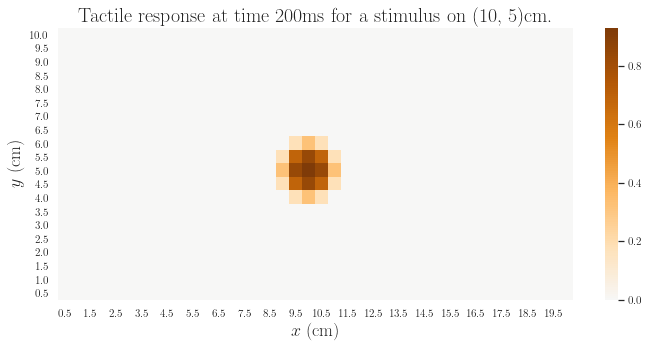

In [1641]:
p_tac = PPS(200, tac_stimulus=(0, 10, 5))
p_tac.simulate()
p_tac.plot_response(200, 'tactile', save='3-3-1')

 Response of the auditory area neurons for an auditory stimulus placed at $(100, 5)\mathrm{cm}$.

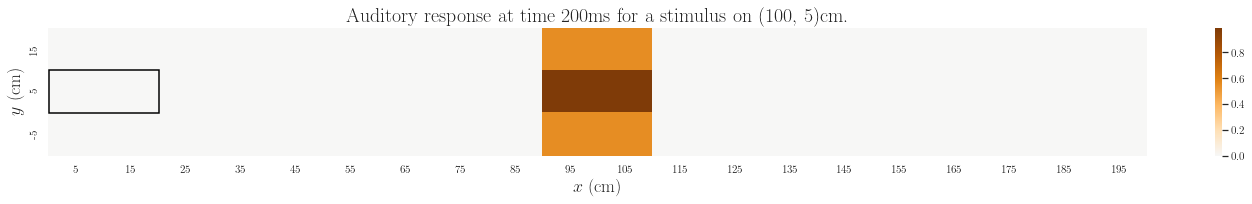

In [1579]:
p_aud = PPS(200, aud_stimulus=(0, 100, 5))
p_aud.simulate()
p_aud.plot_response(200, 'auditory', save='3-3-2')

### The role of the Lateral connections in the repsonses

Simulation run with different values of $L_{ex}^s$ and $L_{in}^s$:

1. $L_{ex}^s = 0 \text{, and } L_{in}^s = 0$
2. $L_{ex}^s = 2 \text{, and } L_{in}^s = 0.05$
3. $L_{ex}^s = 2 \text{, and } L_{in}^s = 0.667$

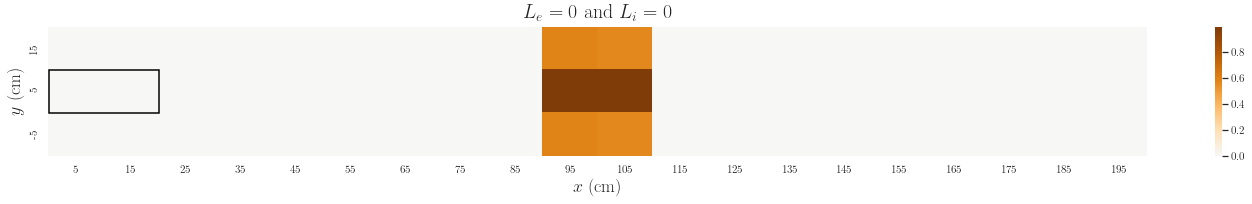

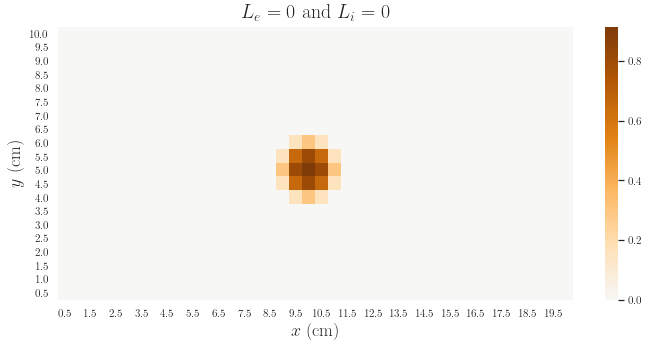

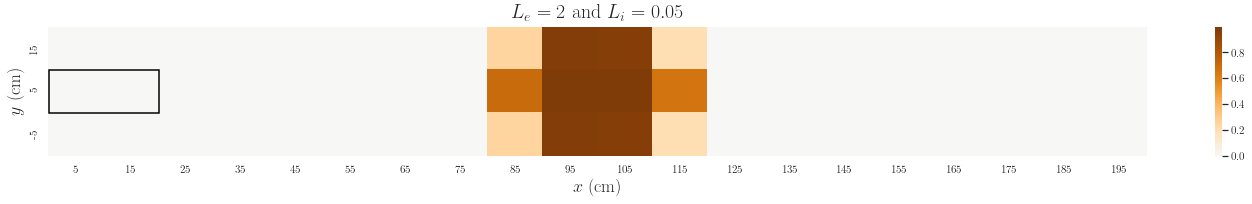

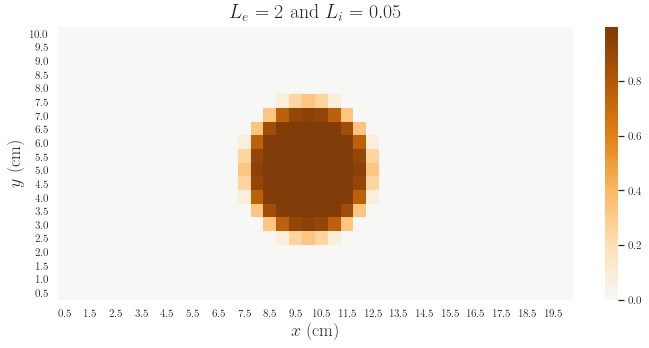

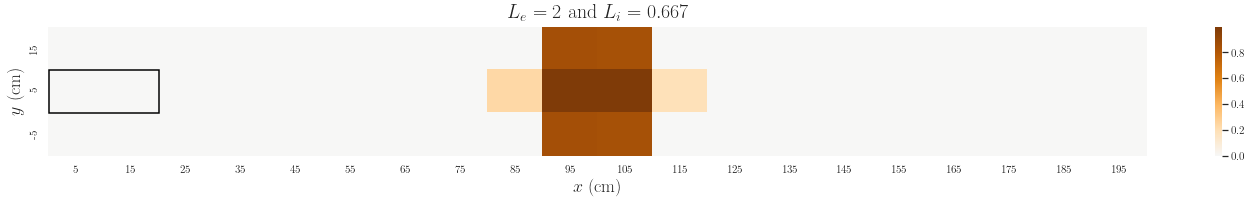

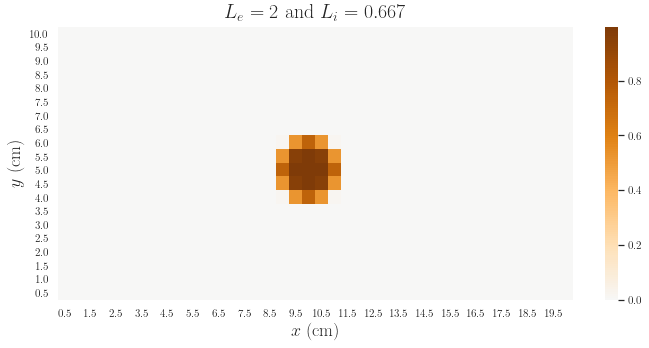

In [39]:
Ls = [[0,0], [2, 0.05], [2, 0.667]]

for n, l in enumerate(Ls):
    p = PPS(200, tac_stimulus=(0, 10, 5),
            aud_stimulus=(0, 100, 5), 
            aud_lateral=l + [20, 80], tac_lateral=l + [1, 4])
    p.simulate()
    p.plot_response(200, 'auditory', title_params=l, save=f'3-3-3-aud-{n}')
    p.plot_response(200, 'tactile', title_params=l, save=f'3-3-3-tac-{n}')


### The effect of the position of the auditory stimulus in the multisensory neuron

Simulations run with different $x$ coordinates of the auditory stimulus. 

The times when the multisensory neuron reaches $10\%$ and $90\%$ of their activity are printed.

In [1421]:
aud_inputs = [(0, 20, 5), (0, 60, 5), (0, 100, 5), (0, 140, 5), (0, 180, 5)]

for aud in aud_inputs:
    p = PPS(200, aud_stimulus=aud, tac_stimulus=(0, 10, 5))
    p.simulate(fired=0)
    #p.plot_response(200)

Started firing 30.400000000000002
Reached 0.9 at time 37.2
Started firing 30.400000000000002
Reached 0.9 at time 37.2
Started firing 38.400000000000006
Reached 0.9 at time 48.0
Started firing 39.6
Reached 0.9 at time 50.0
Started firing 40.0
Reached 0.9 at time 50.0


### The role of the feedback connections

Getting the dynamic state of the auditory neurons after running the simulation with a tactile stimulus only

In [1422]:
p_tac_1 = PPS(200, tac_stimulus=(0, 10, 5))
p_tac_1.simulate()
log_tac_1 = p_tac_1.log['ds']['auditory']
print(f'Maximum auditory stimulation {np.max(log_tac_1)}')


Maximum auditory stimulation 2.498887044316494


Getting the dynamic state of the tactile neurons after running the simulation with an audiotry stimulus only

In [40]:
p_aud_1 = PPS(200, aud_stimulus=(0, 20, 5))
p_aud_1.simulate()
log_aud_1 = np.max(p_aud_1.log['ds']['tactile'])
print(f'Maximum tactile stimulation {log_aud_1}')

Maximum tactile stimulation 2.4990592920974155


Getting the reaction times of the tactile neurons

1. Without an auditory stimulus
2. With an auditory stimulus on $(40,5)\mathrm{cm}$

In [1427]:
p_1 = PPS(200, tac_stimulus=(0, 10, 5))
p_2 = PPS(200, tac_stimulus=(0, 10, 5), aud_stimulus=(0, 40, 5))

print(f'Without auditory stimulus: {p_1.reaction_time()}')
print(f'With auditory stimulus: {p_2.reaction_time()}')

Without auditory stimulus: 85.60000000000001
With auditory stimulus: 78.80000000000001


### Influence of the distance of the auditory stimulus on the Reaction Times


Activity of the multisensory neuron as a function of time, when the auditory stimulus is
presented with $x_a = 19, 34, 55, 76, 91 \mathrm{cm}$. 

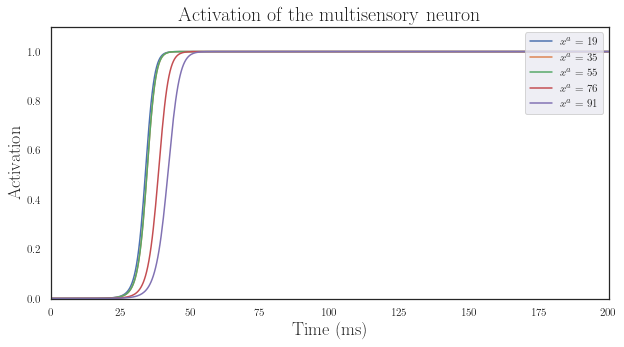

In [12]:
aud_stimuli = [(0, 19, 5), (0, 35, 5), 
               (0, 55, 5), (0, 76, 5), 
               (0, 91, 5)]

legend = []
with sns.axes_style("white"):    
    fig = plt.figure(figsize=(10,5))
    plt.xlim([0,200])
    plt.ylim([0,1.1])
    plt.title('Activation of the multisensory neuron', fontsize=20)
    plt.xlabel('Time (ms)', fontsize=18)
    plt.ylabel('Activation', fontsize=18)
    for aud in aud_stimuli:
        p = PPS(200, tac_stimulus=(0, 10, 5), aud_stimulus=aud)
        p.simulate()
        plt.plot(p.times, p.log['z']['multisensory'])
        legend.append(f'$x^a$ = {aud[1]}')
    
plt.legend(legend, loc='upper right')
plt.savefig('report/fig/4-1.pdf', format='pdf')

Reaction times, $RT$s, as a function of distance, when the auditory stimulus is presented with $x_a$
varying from $10$cm to $190$cm in steps of $10$cm.

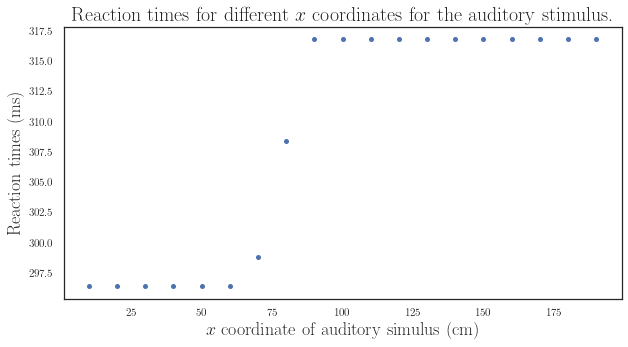

In [43]:
dist = np.arange(10, 200, 10)

rts = []
for d in dist:
    p = PPS(200, tac_stimulus=(0, 10, 5), aud_stimulus=(0, d, 5), pruning=60)
    rt = p.reaction_time(real=True)
    rts.append(rt)

legend = []
with sns.axes_style("white"):
    fig = plt.figure(figsize=(10,5))
    plt.title('Reaction times for different $x$ coordinates for the auditory stimulus.', fontsize=20)
    plt.xlabel('$x$ coordinate of auditory simulus (cm)', fontsize=18)
    plt.ylabel('Reaction times (ms)', fontsize=18)
    plt.plot(dist, rts, marker='.', ls='', mew=2)
    
plt.savefig('report/fig/3-4-2.pdf', format='pdf')

Fitting a sigmoid to get the boundary of the PPS and its steepness.

By trial and error, **boundary of the PPS** (centre of the sigmoid) is $88\mathrm{cm}$. The steepness is $0.11$. 

81.8

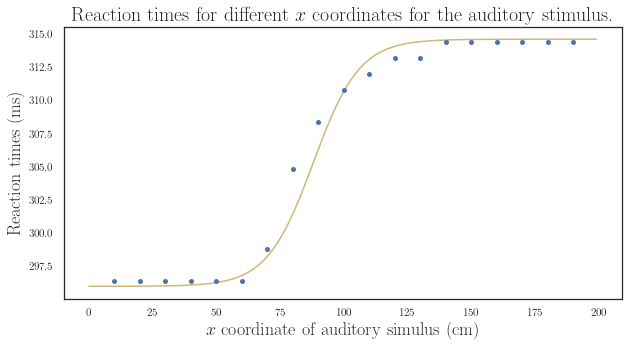

In [18]:
def sigmoid(x, lower, upper, center, slope):
    y = ((lower + upper * np.exp((x - center) * slope)) / 
         (1 + np.exp((x - center) * slope)))
    return y


dist_sigmoid = np.arange(0, 200, 1)

sigmoid_normal = [296, 314.6, 88, 0.11]

with sns.axes_style("white"):
    fig = plt.figure(figsize=(10,5))
    #plt.xlim([0,200])
    #plt.ylim([0,1.1])
    plt.title('Reaction times for different $x$ coordinates for the auditory stimulus.', fontsize=20)
    plt.xlabel('$x$ coordinate of auditory simulus (cm)', fontsize=18)
    plt.ylabel('Reaction times (ms)', fontsize=18)
    #plt.plot(dist2, sigmoid(dist2, 78.8, 84.8, 85, 0.09), 'r-', label='fit')
    plt.plot(dist_sigmoid, sigmoid(dist_sigmoid, *sigmoid_normal), color='y')
    plt.plot(dist, rts, marker='.', ls='', mew=2, color='b')
    
    
plt.savefig('report/fig/3-4-3.pdf', format='pdf')



sigmoid(85, 78.8, 84.8, 85, 0.09)

### Differences in Schizophrenic patients

In schizophrenia, it is found that the PPS are narrower, and the slope is sharper. This is believed to play a crucial role in the abnormal experiences of the self observed in schizophrenia. Similar differences have been found in autism.

One of the mechanisms proposed to explain this is a systematic pruning of the weakest feedforward and feedback connections, which causes the boundary of the PPS to be smaller and steeper.


Reaction times, $RT$s, as a function of distance, when the auditory stimulus is presented with $x_a$ varying from $10$cm to $190$cm in steps of $10$cm, with a pruning of $60\%$.

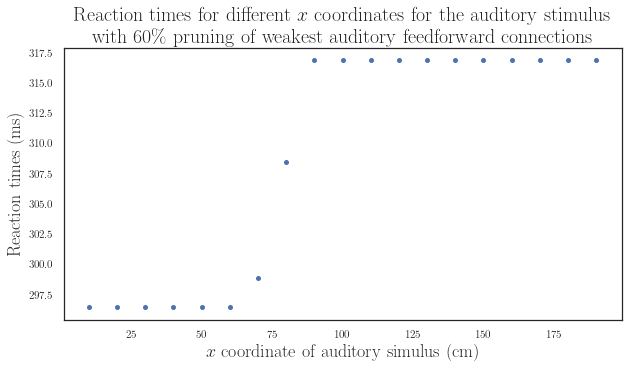

In [26]:
rts_sch = []
pruning = 60
for d in dist:
    #print(f'\nDistance {d}m')
    p = PPS(200, tac_stimulus=(0, 10, 5), aud_stimulus=(0, d, 5), pruning=pruning)
    rt = p.reaction_time(real=True)
    #print(f'Distance {d}m: {rt}ms')
    rts_sch.append(rt)

with sns.axes_style("white"):
    fig = plt.figure(figsize=(10,5))
    #plt.xlim([0,200])
    #plt.ylim([0,1.1])
    plt.title(f"""Reaction times for different $x$ coordinates for the auditory stimulus 
    with {pruning}\% pruning of weakest auditory feedforward connections""", fontsize=20)
    plt.xlabel('$x$ coordinate of auditory simulus (cm)', fontsize=18)
    plt.ylabel('Reaction times (ms)', fontsize=18)
    plt.plot(dist, rts_sch, marker='.', ls='', mew=2)
    
plt.savefig('report/fig/3-5.pdf', format='pdf')

Fitting a new sigmoid to obtain a new boundary for the PPS of $78\mathrm{cm}$ with a steepness of $0.3$.

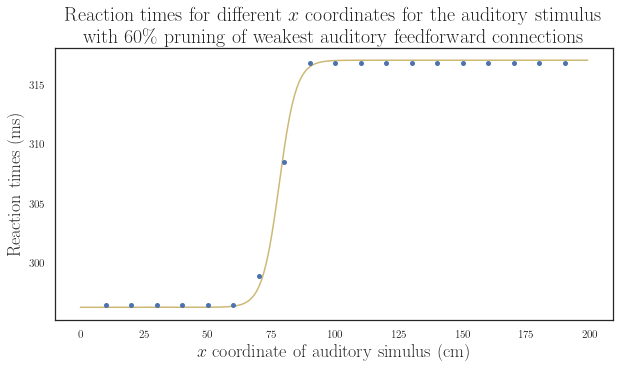

In [34]:
sigmoid_pruning = [296.2, 317, 78, 0.3]

with sns.axes_style("white"):
    fig = plt.figure(figsize=(10,5))
    plt.title(f"""Reaction times for different $x$ coordinates for the auditory stimulus 
    with {pruning}\% pruning of weakest auditory feedforward connections""", fontsize=20)
    plt.xlabel('$x$ coordinate of auditory simulus (cm)', fontsize=18)
    plt.ylabel('Reaction times (ms)', fontsize=18)
    
    plt.plot(dist_sigmoid, sigmoid(dist_sigmoid, *sigmoid_pruning), color='y')
    plt.plot(dist, rts_sch, marker='.', ls='', mew=2, color='b')
    
plt.savefig('report/fig/3-5.pdf', format='pdf')